In [1]:
# Francisco Dominguez Mateos
# 02/07/2020
# SIREN
# from:https://www.youtube.com/watch?v=Q5g3p9Zwjrk
#      https://vsitzmann.github.io/siren/
# baseline: https://cs.stanford.edu/people/karpathy/convnetjs/demo/image_regression.html
# 07/08/2020 added gradient

In [2]:
import time
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import cv2

In [3]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [4]:
def Siren(s=[1000]*5,omega_0=30.0):
    def init_fun(key,input_shape):
        """ Initialize the weights of all layers of a linear layer network """
        sizes=[input_shape[-1]]+s
        print(sizes)
        keys = random.split(key, len(sizes))
        print(len(keys))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, rng):
            scale=np.sqrt(6.0/float(m))/omega_0
            w_key, b_key = random.split(rng)
            return scale * random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        # actually they are pairs plus the random key
        pairs=list(zip(sizes[:-1], sizes[1:], keys))
        params=[initialize_layer(m, n, k) for m, n, k in pairs[:]]
        # The scale of first layes is different
        m,n,k=pairs[0]
        w_key, b_key = random.split(k)
        scale=1.0/float(m)
        print("scale",m,n,scale)
        params[0]=scale*random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        output_shape =  input_shape[:-1] + (sizes[-1],)
        return (output_shape,params)
    def apply_fun(params, inputs, **kwargs):
        """ Compute the forward pass for each example individually """
        activations = inputs
        # Loop over the Siren hidden layers
        for w, b in params[:-1]:
            linear = np.dot(w,activations)+b
            activations=np.sin(omega_0*linear)
        w,b=params[-1]
        linear= np.dot(w,activations)+b
        #return activations#.reshape(())
        return linear#.reshape(())
    return init_fun, apply_fun

In [5]:
init,net=Siren([256]*3+[3])
input_shape=(-1,2)
output_shape,params=init(rng,input_shape)
print(len(params))
for l in params:
    print(l[0].shape,l[1].shape)

[2, 256, 256, 256, 3]
5
scale 2 256 0.5
4
(256, 2) (256,)
(256, 256) (256,)
(256, 256) (256,)
(3, 256) (3,)


In [6]:
def net_pre_grad(params,x):
    p=net(params,x)
    a=np.mean(p)
    return a.reshape(())

In [7]:
net_grad=grad(net_pre_grad,argnums=1)

In [8]:
# Make a batched version of the `net` function
batch_net      = vmap(net     , in_axes=(None, 0), out_axes=0)
batch_net_grad = vmap(net_grad, in_axes=(None, 0), out_axes=0)

In [9]:
X, Y = np.meshgrid(range(225),range(225))
xy=np.dstack((Y,X))
input_ordered=np.reshape(xy,(-1,2))
print(input_ordered.shape)

(50625, 2)


In [10]:
def getInputOrdered(size):
    width=size[1]
    height=size[0]
    X, Y = np.meshgrid(range(height),range(width))
    X=X/height*2.0-1.0
    Y=Y/width *2.0-1.0
    xy=np.dstack((Y,X))
    input_ordered=np.reshape(xy,(-1,2))
    return input_ordered

def build_img(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width,3))

def build_sdf_grad(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net_grad(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width,2))

(2500, 2)
(2500, 3)
0.10169558 -0.09234505


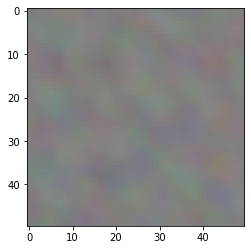

In [11]:
W=50
H=50
#input_ordered=getInputOrdered((H,W))
img=build_img((H,W))
print(np.max(img),np.min(img))
plt.imshow((img+1.0)/2.0)

In [12]:
W=50
H=50
#input_ordered=getInputOrdered((H,W))
img=build_sdf_grad((H,W))
print(np.max(img),np.min(img))

(2500, 2)
(2500, 2)
0.71861684 -0.76804996


0.4833745 -0.51662546
(2500, 3)


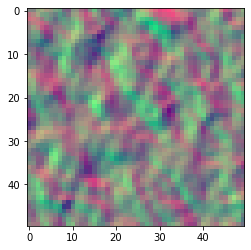

In [13]:
gsdf_values=img.reshape((-1,2))
gmax=np.max(gsdf_values)
gmin=np.min(gsdf_values)
s=gmax-gmin
gsdf_values/=s
print(np.max(gsdf_values),np.min(gsdf_values))
z=np.zeros((gsdf_values.shape[0],1))
v=np.hstack((gsdf_values,z))
print(v.shape)
img=np.reshape(v,(H,W,3))
plt.imshow((img-np.min(gsdf_values)))

(225, 225, 3)
(50625, 3) 1.0 -1.0


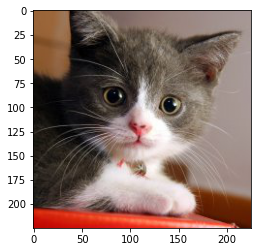

In [14]:
img_bgr=cv2.imread('cat.jpg')
img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img=img_rgb/255.0*2.0-1.0
plt.imshow((img+1.0)/2.0)
#plt.imshow(img_rgb)
print(img.shape)
img_flat=np.reshape(img,(-1,3))
print(img_flat.shape,np.max(img_flat),np.min(img_flat))
input_ordered=getInputOrdered((img.shape[0],img.shape[1]))


In [15]:
@jit
def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = batch_net(params, inputs)
    return np.mean((preds - targets)**2)
@jit
def accuracy(params,inputs,targets):
    return mse_loss(params,inputs,targets)
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [16]:
print(input_ordered.shape)
print(img_flat.shape)
mse_loss(params,input_ordered,img_flat)

(50625, 2)
(50625, 3)


DeviceArray(0.29317483, dtype=float32)

In [17]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [18]:
num_epochs = 500

In [19]:
def run_training_loop(num_epochs, opt_state):
    global params
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params,input_ordered,img_flat)
    test_acc  = accuracy(params,input_ordered,img_flat)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss = update(params, input_ordered,img_flat, opt_state)
        train_loss.append(loss)

        train_acc = accuracy(params,input_ordered,img_flat)
        test_acc = accuracy(params,input_ordered,img_flat)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        if(epoch %100 ==0):
            epoch_time = time.time() - start_time
            print("Epoch {} | T: {:0.3f} | Train A: {:0.4f} | Test A: {:0.4f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    return opt_state, train_loss, log_acc_train, log_acc_test

In [20]:
opt_state, train_loss, train_log, test_log =run_training_loop(num_epochs,opt_state)

Epoch 1 | T: 1.043 | Train A: 0.1922 | Test A: 0.1922
Epoch 101 | T: 0.030 | Train A: 0.0017 | Test A: 0.0017
Epoch 201 | T: 0.030 | Train A: 0.0009 | Test A: 0.0009
Epoch 301 | T: 0.028 | Train A: 0.0006 | Test A: 0.0006
Epoch 401 | T: 0.028 | Train A: 0.0004 | Test A: 0.0004


(50625, 2)


(50625, 3)
1.0243202 -0.027637184


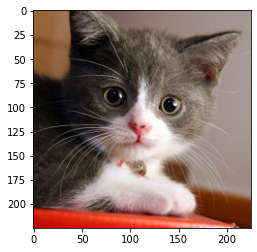

In [21]:
img=build_img((225,225))
print(np.max((img+1.0)/2.0),np.min((img+1.0)/2.0))
plt.imshow((img+1.0)/2.0)

In [22]:
W=225
H=225
input_ordered=getInputOrdered((H,W))
img=build_sdf_grad((H,W))
print(np.max(img),np.min(img))

(50625, 2)
(50625, 2)
132.90688 -152.60344


0.4655064 -0.5344936
(50625, 3)


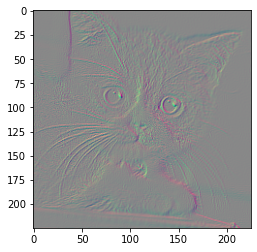

In [23]:
gsdf_values=img.reshape((-1,2))
gmax=np.max(gsdf_values)
gmin=np.min(gsdf_values)
s=gmax-gmin
gsdf_values/=s
print(np.max(gsdf_values),np.min(gsdf_values))
z=np.zeros((gsdf_values.shape[0],1))
v=np.hstack((gsdf_values,z))
print(v.shape)
img=np.reshape(v,(H,W,3))
plt.imshow((img-np.min(gsdf_values)))